## Ideal example

Create the figure from the Discussion section in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). The figure will show two examples to give some intuition for potential pitfalls when applying the Lompe technique.

We start by importing the relevant modules:

In [1]:
import numpy as np
import lompe
import matplotlib.pyplot as plt

Set conductance levels and color scales for plots:

In [2]:
SIGMA_MAX = 10    # conductance in high-conductance regions
SIGMA_MIN = 1e-2  # conductance in low-conductance region
Blevels = np.linspace(-100, 100, 40) * 1e-9 # color scale for magnetic field [T]
FAClevels = np.linspace(-15, 15, 22) * 1e-6 # color scale for FAC [A/m^2]

##### Grid
Set up cubed sphere grids:

In [3]:
R = (6371.2 + 110) * 1e3
L, W1 = 700e3, 500e3
dL, dW = 10e3, 10e3
L0, L1 = 55, 57
lon = 0 
W2 = (L1 - L0)*.9*np.pi/180 * R # width of second grid
SKIP = 5

p = lompe.cs.CSprojection((-90, (L0 + L1)/2), 0)
grid_ex1 = lompe.cs.CSgrid(p, L, W1, dL, dW, R = R)
grid_ex2 = lompe.cs.CSgrid(p, L, W2, dL, dW, R = R, wshift = -dW/2)

##### Conductance
We define the conductance function

In [4]:
def c(lon, lat):
    c = np.ones_like(lon) * SIGMA_MAX
    c[(lat > L0) & (lat < L1)]*=SIGMA_MIN
    return(c)

##### Set up model, add ideal (synthetic) data and plot
Initiate the model objects, create synthetic data to add to them and run iversions.

In [5]:
##### CASE 1 - FLOW SHEAR
model_ex1 = lompe.Emodel(grid_ex1, Hall_Pedersen_conductance = (c, c), dipole = True)

# make synthetic data of flow shear
ve = np.ones(grid_ex1.shape) * 500
ve[(grid_ex1.lat > L0) & (grid_ex1.lat < L1)] *= -1
vn = np.zeros(grid_ex1.shape)

# make Lompe data object and add to model
vdata = lompe.Data(np.vstack((ve.flatten(), vn.flatten())), coordinates = np.vstack((grid_ex1.lon.flatten(), grid_ex1.lat.flatten())), datatype = 'convection')
model_ex1.add_data(vdata)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model_ex1.run_inversion(l1 = 1e-1);


###### CASE 2 - Use output from the first example as input
model_ex2 = lompe.Emodel(grid_ex2, Hall_Pedersen_conductance = (c, c), dipole = True)

# make input data from CASE 1 output
Be_in, Bn_in, Bu_in = model_ex1.B_ground(model_ex2.grid_E.lon.flatten(), model_ex2.grid_E.lat.flatten())

# make Lompe data object and add to model
Bdata = lompe.Data(np.vstack((Be_in, Bn_in, Bu_in)), np.vstack((model_ex2.grid_E.lon.flatten(), model_ex2.grid_E.lat.flatten())), datatype = 'ground_mag')
model_ex2.add_data(Bdata)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model_ex2.run_inversion(l1 = 1e-1);

We make the figure and plot the CASES:

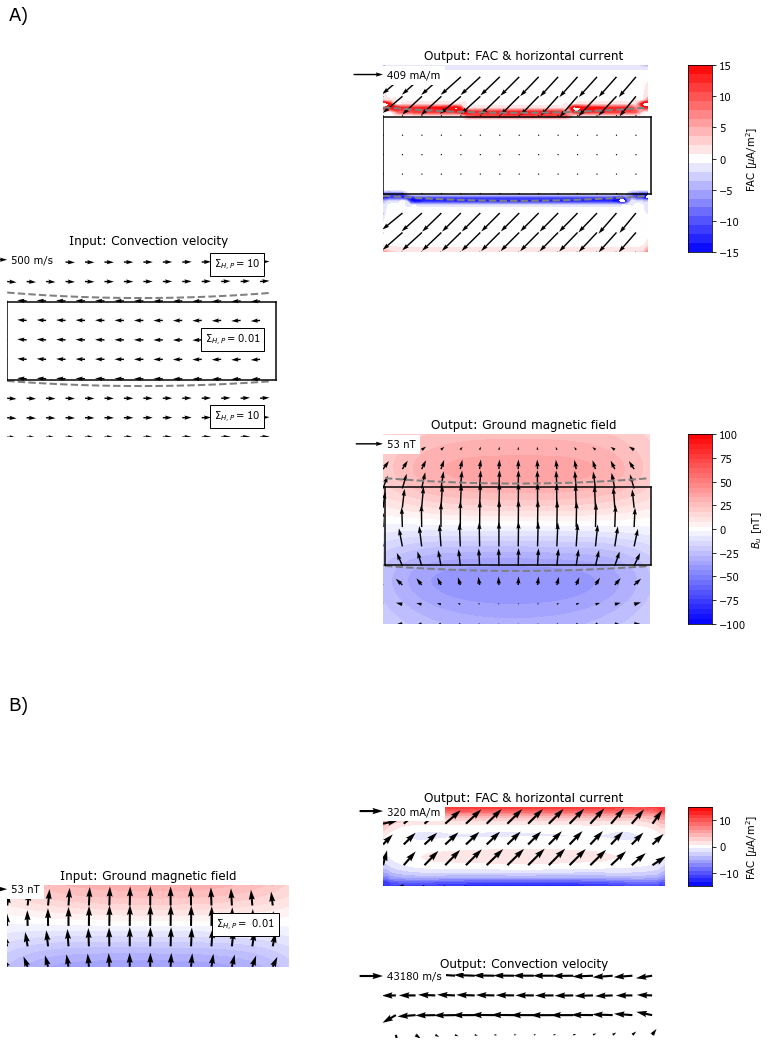

In [6]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (9*1.25, 12*1.25))

ex1, ex2 = {}, {} # initialize dictionaries for axes

ex1['input' ] = plt.subplot2grid((40, 30), ( 7,  0), rowspan = 12, colspan = 12)
ex1['model' ] = plt.subplot2grid((40, 30), ( 0, 16), rowspan = 12, colspan = 12)
ex1['output'] = plt.subplot2grid((40, 30), (14, 16), rowspan = 12, colspan = 12)
ex1['cbar' ]  = plt.subplot2grid((40, 30), ( 0, 29), rowspan = 12)
ex1['cbar2' ] = plt.subplot2grid((40, 30), (14, 29), rowspan = 12)
ex1['label'] = plt.subplot2grid((40, 30), (1, 0))

ex2['input' ] = plt.subplot2grid((40, 30), (33,  0), rowspan = 4, colspan = 12)
ex2['model' ] = plt.subplot2grid((40, 30), (30, 16), rowspan = 4, colspan = 12)
ex2['output'] = plt.subplot2grid((40, 30), (36, 16), rowspan = 4, colspan = 12)
ex2['cbar'  ] = plt.subplot2grid((40, 30), (30, 29), rowspan = 4)
ex2['label'] = plt.subplot2grid((40, 30), (27, 0))

plt.subplots_adjust(hspace = 0, wspace = 0, left = 0.05, right = .92, bottom = 0.01 ,top = .99)

# labels:
ex1['label'].set_axis_off()
ex2['label'].set_axis_off()

ex1['label'].set_title('A)', fontsize = 18)
ex2['label'].set_title('B)', fontsize = 18)

# get vectors for CASE 1
vx, vy = p.vector_cube_projection(ve, vn, model_ex1.grid_J.lon, model_ex1.grid_J.lat, return_xi_eta = False)
vx, vy = vx.reshape(model_ex1.grid_J.shape), vy.reshape(model_ex1.grid_J.shape)

# input data CASE 1
q = ex1['input'].quiver(model_ex1.grid_J.xi[::SKIP, ::SKIP], model_ex1.grid_J.eta[::SKIP, ::SKIP], vx[::SKIP, ::SKIP], vy[::SKIP, ::SKIP], scale = 15000)
vscale = ve.max()
# output data CASE 1
t = ex1['output'].quiverkey(q, 0, .95, vscale, r'' + '{:.0f} m/s'.format(vscale), labelpos='E', labelsep = 0.05)
t.text.set_backgroundcolor('w')

# plot magnetic field output from CASE 1
Be, Bn, Bu = model_ex1.B_ground()
ex1['output'].contourf(model_ex1.grid_E.xi, model_ex1.grid_E.eta, Bu.reshape(model_ex1.grid_E.shape), levels = Blevels, cmap = plt.cm.bwr)

Bx, By = p.vector_cube_projection(Be, Bn, model_ex1.grid_E.lon, model_ex1.grid_E.lat, return_xi_eta = False)
Bx, By = Bx.reshape(model_ex1.grid_E.shape), By.reshape(model_ex1.grid_E.shape)
q = ex1['output'].quiver(model_ex1.grid_E.xi[::SKIP, ::SKIP], model_ex1.grid_E.eta[::SKIP, ::SKIP], Bx[::SKIP, ::SKIP], By[::SKIP, ::SKIP])
Bmax = np.sqrt(np.max(Bn**2 + Be**2))
t = ex1['output'].quiverkey(q, 0, .95, Bmax, r'' + '{:.0f} nT'.format(Bmax*1e9), labelpos='E', labelsep = 0.05)
t.text.set_backgroundcolor('w')

# color scale:
x = np.vstack((np.zeros(Blevels.size), np.ones(Blevels.size))).T
y = np.vstack((Blevels, Blevels)).T
ex1['cbar2'].contourf(x, y*1e9, y*1e9, levels = Blevels*1e9, cmap = plt.cm.bwr)
ex1['cbar2'].set_xticks([])
ex1['cbar2'].yaxis.set_label_position("right")
ex1['cbar2'].yaxis.tick_right()
ex1['cbar2'].set_ylabel('$B_u$ [nT]')
ex1['input' ].set_title('Input: Convection velocity')
ex1['model' ].set_title('Output: FAC & horizontal current')
ex1['output'].set_title('Output: Ground magnetic field')

for key in ex1.keys():
    if 'cbar' in key or 'label' in key:
        continue
    ex1[key].set_axis_off()
    ex1[key].set_aspect('equal')
    ex1[key].contour(grid_ex1.xi, grid_ex1.eta, grid_ex1.lat, levels = [L0, L1], linestyles = '--', colors = 'grey', linewidths = 2)

    xi, eta = grid_ex2.xi_mesh[0 ,  :], grid_ex2.eta_mesh[ 0,  :]
    ex1[key].plot(xi, eta, color = 'black', linewidth = 1.5)
    xi, eta = grid_ex2.xi_mesh[: ,  0], grid_ex2.eta_mesh[ :,  0]
    ex1[key].plot(xi, eta, color = 'black', linewidth = 1.5)
    xi, eta = grid_ex2.xi_mesh[-1,  :], grid_ex2.eta_mesh[-1,  :]
    ex1[key].plot(xi, eta, color = 'black', linewidth = 1.5)
    xi, eta = grid_ex2.xi_mesh[: , -1], grid_ex2.eta_mesh[ :, -1]
    ex1[key].plot(xi, eta, color = 'black', linewidth = 1.5)


ex1['input'].text(grid_ex1.xi_max*.9, grid_ex1.eta_max*.8, r'$\Sigma_{H,P} =$' + '{:.0f}'.format(SIGMA_MAX), bbox = {'facecolor':'white'}, ha = 'right')
ex1['input'].text(grid_ex1.xi_max*.9,                   0, r'$\Sigma_{H,P} =$' + '{:.2f}'.format(SIGMA_MIN), bbox = {'facecolor':'white'}, ha = 'right')
ex1['input'].text(grid_ex1.xi_max*.9, grid_ex1.eta_min*.8, r'$\Sigma_{H,P} =$' + '{:.0f}'.format(SIGMA_MAX), bbox = {'facecolor':'white'}, ha = 'right')


# plot current densities in both CASES
for model, ex in zip([model_ex1, model_ex2], [ex1, ex2]):

    je, jn = model.j()
    fac = -model.Ddiv.dot(np.hstack((je, jn)))

    ex['model'].contourf(model.grid_J.xi, model.grid_J.eta, fac.reshape(model.grid_J.shape), cmap = plt.cm.bwr, levels = FAClevels)

    jx, jy = p.vector_cube_projection(je, jn, model.grid_J.lon, model.grid_J.lat, return_xi_eta = False)
    jx, jy = jx.reshape(model.grid_J.shape), jy.reshape(model.grid_J.shape)
    q = ex['model'].quiver(model.grid_J.xi[::SKIP, ::SKIP], model.grid_J.eta[::SKIP, ::SKIP], jx[::SKIP, ::SKIP], jy[::SKIP, ::SKIP])

    # add quiver key
    jmax = np.sqrt(np.max(jn**2 + je**2))
    t = ex['model'].quiverkey(q, 0, .95, jmax, r'' + '{:.0f} mA/m'.format(jmax*1000), labelpos='E', labelsep = 0.05)
    t.text.set_backgroundcolor('w')

    # color scale for FACs
    x = np.vstack((np.zeros(FAClevels.size), np.ones(FAClevels.size))).T
    y = np.vstack((FAClevels, FAClevels)).T
    ex['cbar'].contourf(x, y*1e6, y*1e6, levels = FAClevels*1e6, cmap = plt.cm.bwr)
    ex['cbar'].set_xticks([])
    ex['cbar'].yaxis.set_label_position("right")
    ex['cbar'].yaxis.tick_right()
    ex['cbar'].set_ylabel('FAC [$\mu$A/m$^2$]')


# plot input in CASE 2
ex2['input'].contourf(model_ex2.grid_E.xi, model_ex2.grid_E.eta, Bu_in.reshape(model_ex2.grid_E.shape), levels = Blevels, cmap = plt.cm.bwr)

Bx, By = p.vector_cube_projection(Be_in, Bn_in, model.grid_E.lon, model.grid_E.lat, return_xi_eta = False)
Bx, By = Bx.reshape(model_ex2.grid_E.shape), By.reshape(model_ex2.grid_E.shape)
q = ex2['input'].quiver(model_ex2.grid_E.xi[::SKIP, ::SKIP], model_ex2.grid_E.eta[::SKIP, ::SKIP], Bx[::SKIP, ::SKIP], By[::SKIP, ::SKIP])
Bmax = np.sqrt(np.max(Bn_in**2 + Be_in**2))
t = ex2['input'].quiverkey(q, 0, .95, Bmax, r'' + '{:.0f} nT'.format(Bmax*1e9), labelpos='E', labelsep = 0.05)
t.text.set_backgroundcolor('w')


# plot velocity field in CASE 2
ve, vn = model_ex2.v()
vx, vy = p.vector_cube_projection(ve, vn, grid_ex2.lon, grid_ex2.lat, return_xi_eta = False)
vx, vy = vx.reshape(model_ex2.grid_J.shape), vy.reshape(model_ex2.grid_J.shape)
q = ex2['output'].quiver(model_ex2.grid_J.xi[::SKIP, ::SKIP], model_ex2.grid_J.eta[::SKIP, ::SKIP], vx[::SKIP, ::SKIP], vy[::SKIP, ::SKIP])
vmax = np.sqrt(np.max(vn**2 + ve**2))
t = ex2['output'].quiverkey(q, 0, .95, vmax, r'' + '{:.0f} m/s'.format(vmax), labelpos='E', labelsep = 0.05)
t.text.set_backgroundcolor('w')


ex2['input' ].set_title('Input: Ground magnetic field')
ex2['model' ].set_title('Output: FAC & horizontal current')
ex2['output'].set_title('Output: Convection velocity')

for key in ex2.keys():
    if 'cbar' in key:
        continue
    ex2[key].set_axis_off()
    ex2[key].set_aspect('equal')

ex2['input'].text(grid_ex2.xi_max*.9,0, r'$\Sigma_{H, P} =$ ' + '{:.2f}'.format(SIGMA_MIN), bbox = {'facecolor':'white'}, ha = 'right')

# force the color bars to have same height as corresponding plots
for ax_d, ax_c in zip([ex1['model'], ex1['output'], ex2['model']], [ex1['cbar'], ex1['cbar2'], ex2['cbar']]):
    grid_pos = ax_d.get_position().get_points().flatten()
    cbar_pos = ax_c.get_position().get_points().flatten()
    ax_c.set_position([cbar_pos[0], grid_pos[1], cbar_pos[2] - cbar_pos[0], grid_pos[3] - grid_pos[1]])



# save figure
plt.savefig('output_figures/ideal_examples.pdf')
plt.savefig('output_figures/ideal_examples.png', dpi = 250)

Two theoretical examples of how the Lompe inversion can give misleading results:

A) The input (left) is a flow field that is eastward except for in a confined latitude band (dashed gray lines) where it is westward. The conductance is 10 mho outside and 0.01 mho inside the band. The right plots show the current and ground magnetic field implied by Lompe inversion results. 

B) The analysis region is the rectangle indicated in A, and the input is the magnetic field from A (shown to the left). The right plots show current densities and flow field implied by the Lompe inversion.